# Instllation and Setup

In [204]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Data Preprocessing and Visualization

In [101]:
# Collect historical data
nifty_data = yf.download('^NSEI', start='2022-05-10', end='2024-05-10')
nasdaq_data = yf.download('^IXIC', start='2021-05-10', end='2024-05-10')
gold_data = yf.download('GC=F', start='2021-05-10', end='2024-05-10')
oil_data = yf.download('CL=F', start='2021-05-10', end='2024-05-10')


n50_pe_file = 'data/NIFTY50_Historical_PE_PB_DIV_Data_10052022to10052024.csv'
pe = pd.read_csv(n50_pe_file)
pe.rename(columns={'P/E': 'PE'}, inplace=True)
pe['Date'] = pd.to_datetime(pe['Date'], format='%d %b %Y')
pe.set_index('Date', inplace=True)
nifty_pe_data = pe

print(f'nifty_data  = {len(nifty_data)}')
print(f'nasdaq_data  = {len(nasdaq_data)}')
print(f'gold_data  = {len(gold_data)}')
print(f'oil_data  = {len(oil_data)}')
print(f'nifty_pe_data  = {len(nifty_pe_data)}')


# Merge dataframes on date index
merged_data = pd.concat([nifty_data['Close'], nasdaq_data['Close'], gold_data['Close'], oil_data['Close'], nifty_pe_data['PE']], axis=1)
merged_data.columns = ['nifty_close', 'nasdaq_close', 'gold_close', 'oil_close', 'nifty_pe']

print(f'merged_data  = {len(merged_data)}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

nifty_data  = 494
nasdaq_data  = 756
gold_data  = 757
oil_data  = 757
nifty_pe_data  = 498
merged_data  = 777


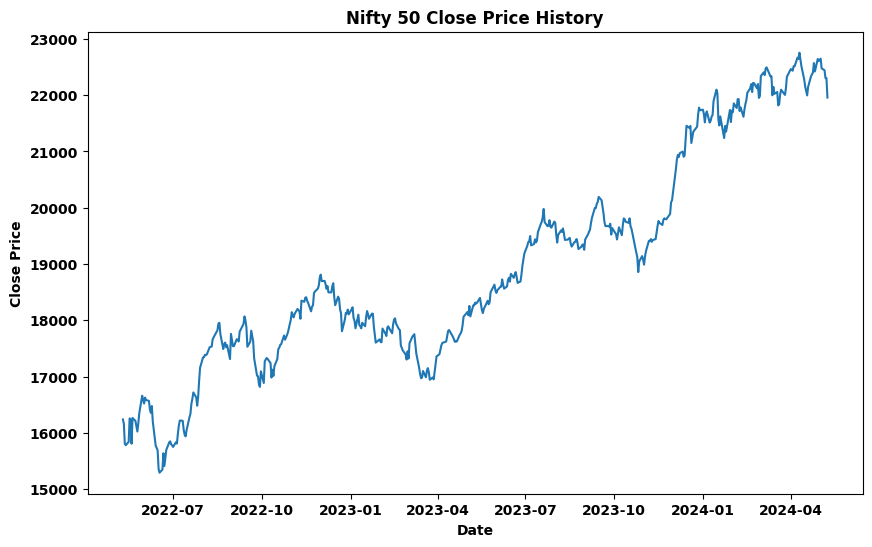

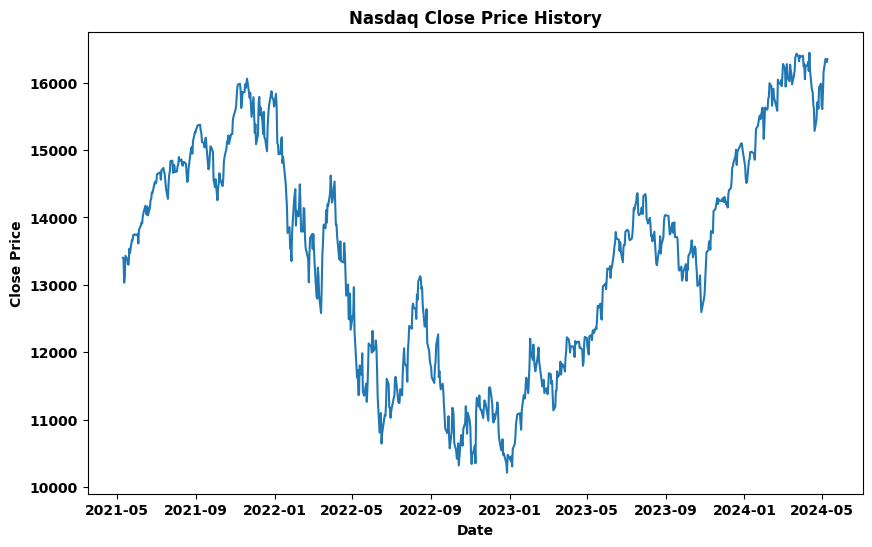

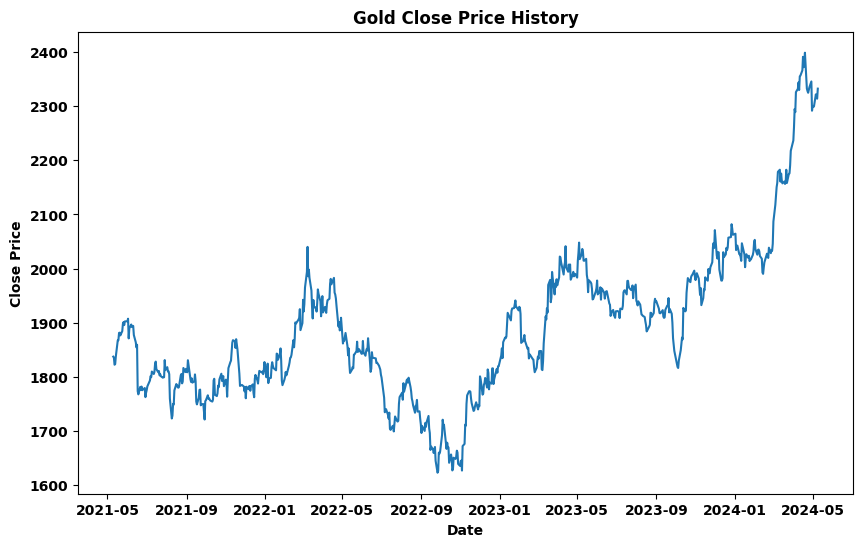

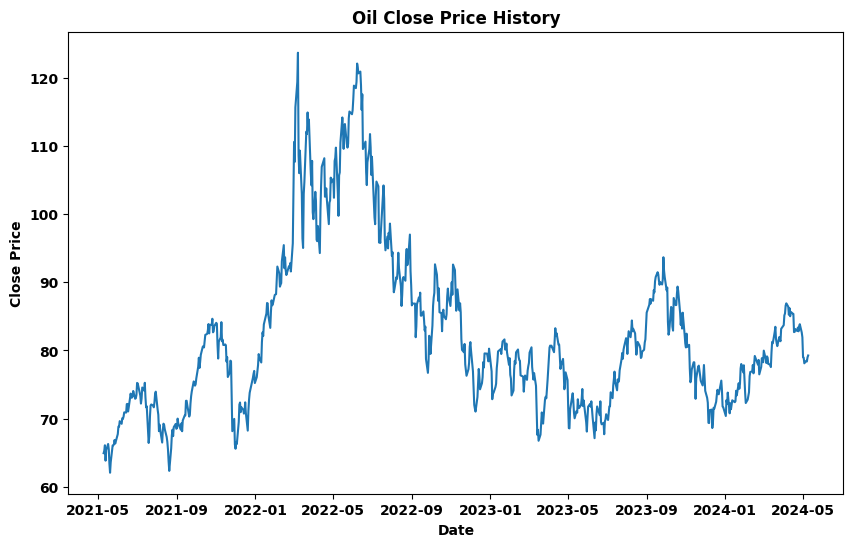

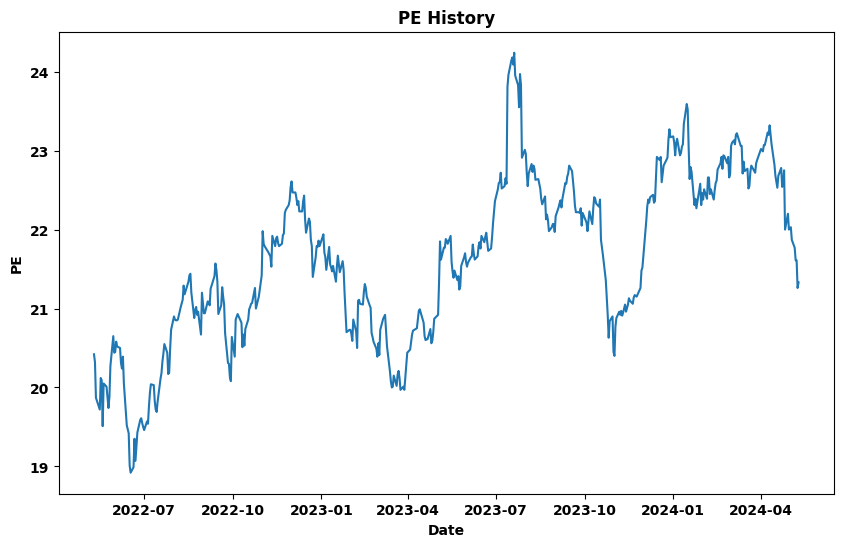

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(nifty_data.index, nifty_data['Close'], label='Nifty 50 Close Price')
plt.title('Nifty 50 Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['Close'], label='Nasdaq Close Price')
plt.title('Nasdaq Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.figure(figsize=(10, 6))
plt.plot(gold_data.index, gold_data['Close'], label='Gold Close Price')
plt.title('Gold Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.figure(figsize=(10, 6))
plt.plot(oil_data.index, oil_data['Close'], label='Oil Close Price')
plt.title('Oil Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.figure(figsize=(10, 6))
plt.plot(nifty_pe_data.index, nifty_pe_data['PE'], label='PE')
plt.title('PE History')
plt.xlabel('Date')
plt.ylabel('PE')

plt.show()

In [102]:
merged_data.dropna(inplace=True)
merged_data.head()

,nifty_close,nasdaq_close,gold_close,oil_close,nifty_pe
Date,,,,,
2022-05-10,16240.049805,11737.669922,1839.900024,99.760002,20.42
2022-05-11,16167.099609,11364.240234,1852.599976,105.709999,20.32
2022-05-12,15808.000000,11370.959961,1823.800049,106.129997,19.87
2022-05-13,15782.150391,11805.000000,1807.400024,110.489998,19.83
2022-05-16,15842.299805,11662.790039,1813.500000,114.199997,19.72


# Build LSTM

In [179]:
# Check if there are any valid data points remaining
if merged_data.shape[0] == 0:
    print("Error: No valid data points remaining after dropping NaN values.")
else:
    # Normalize the features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(merged_data)

    # Separate the features and target
    nifty_close = scaled_features[:, 0].reshape(-1, 1)
    features = scaled_features

    # Define and train LSTM model
    def create_lstm_model():
        model = Sequential()
        model.add(Input(shape=(60, 1)))
        model.add(LSTM(units=60,activation='relu',return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=60,activation='tanh',return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=120,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam',loss='mean_squared_error')
        return model

    lstm_model = create_lstm_model()
    

In [180]:
lstm_model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                      │ (None, 60, 60)              │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_121 (LSTM)                      │ (None, 60, 60)              │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_122 (LSTM)                      │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,921 (511.41 KB)

 Trainable params: 130,921 (511.41 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [181]:
lstm_model.fit(features.reshape(features.shape[0], features.shape[1], 1), nifty_close, epochs=50, batch_size=32)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.2673
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0711
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0390
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0291
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0120
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0114
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0098
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0082
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0071
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0083
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0077
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0062
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0067
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055
Epo

# Making Predictions

In [182]:
    
    # Predict future 90 days using LSTM
    last_2_years_data = scaled_features[-252*2:]
    future_dates = pd.date_range(start='2024-05-11', periods=90)

    lstm_predictions = []
    current_features = last_2_years_data[-1].reshape(1, features.shape[1], 1)
    for _ in range(90):
        lstm_pred = lstm_model.predict(current_features)
        lstm_predictions.append(lstm_pred[0][0])
        current_features = np.roll(current_features, -1)
        current_features[-1][-1] = lstm_pred
        
    # Inverse transform predictions to get actual price values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(nifty_data['Close'].values.reshape(-1, 1))  # Fit the scaler on the original closing prices
    actual_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

# Prediction Visualization

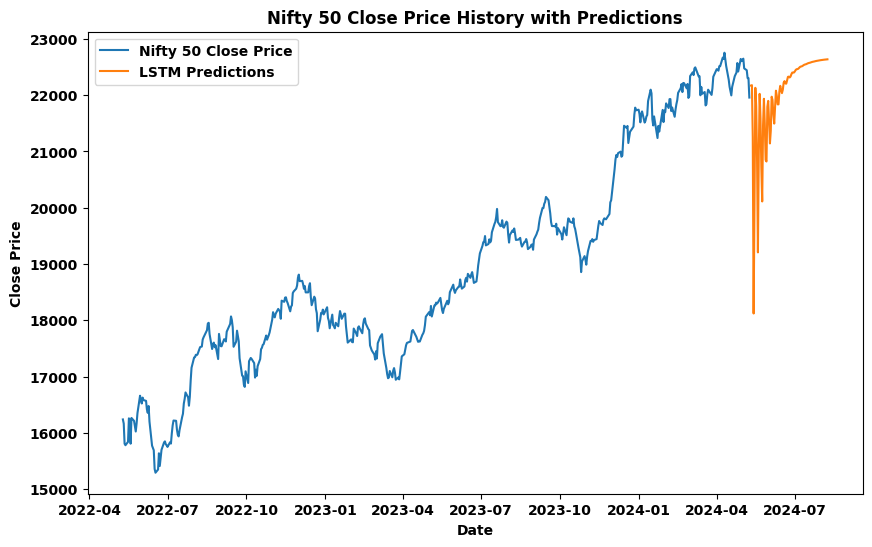

In [183]:
    plt.figure(figsize=(10, 6))
    plt.plot(nifty_data.index, nifty_data['Close'], label='Nifty 50 Close Price')
    plt.plot(future_dates, actual_predictions, label='LSTM Predictions')
    plt.legend()
    plt.title('Nifty 50 Close Price History with Predictions')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

# Prediction and Visualization using ARIMA

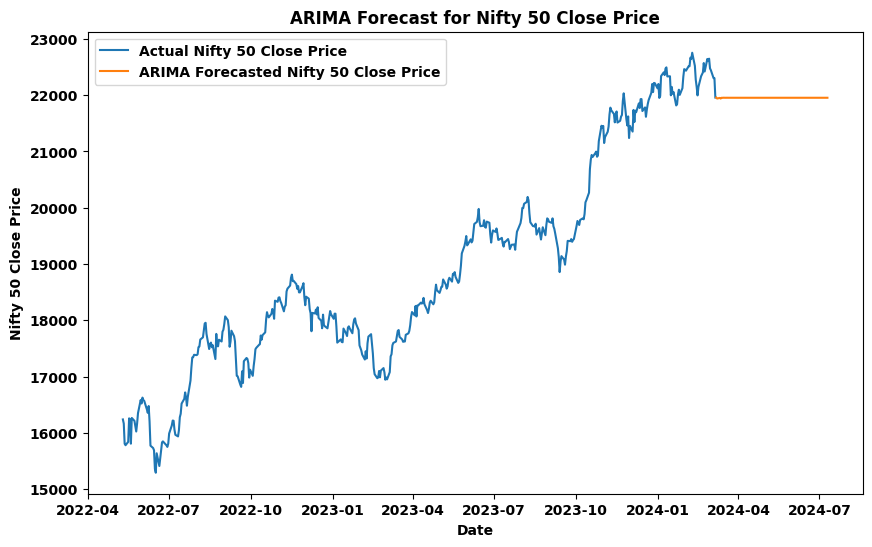

In [205]:
merged_data.index = pd.date_range(start=merged_data.index[0], periods=len(merged_data), freq='B')

# Fit an ARIMA model on Nifty 50 close prices
arima_model = ARIMA(merged_data['nifty_close'], order=(5, 1, 0))  # Example ARIMA order (p, d, q)
arima_model_fit = arima_model.fit()

# Generate predictions
forecast_steps = 90  # Number of future steps to forecast
forecast = arima_model_fit.forecast(steps=forecast_steps)

# Plot actual data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['nifty_close'], label='Actual Nifty 50 Close Price')
plt.plot(pd.date_range(start=merged_data.index[-1], periods=forecast_steps+1, freq='B')[1:], forecast, label='ARIMA Forecasted Nifty 50 Close Price')
plt.xlabel('Date')
plt.ylabel('Nifty 50 Close Price')
plt.title('ARIMA Forecast for Nifty 50 Close Price')
plt.legend()
plt.show()